# Glass Type Classification with Machine Learning

Hey there and welcome to this kernel! My name is Elie. I'm a data science newbie and this is my first Kaggle notebook. I have been putting a lot of effort recently to start my journey in data science. I benefited a lot from the notebooks of other awesome kagglers and I hope you benefit this notebook and learn new stuff from it.

<hr >

# Contents

## 1) Prepare Problem

 * Load libraries

 * Load and explore the shape of the dataset

## 2) Summarize Data

* Descriptive statistics

* Data visualization

## 3) Prepare Data

* Data Cleaning

* Split-out validation dataset

*  Data transformation  

## 4) Evaluate Algorithms

* Dimensionality reduction

* Compare Algorithms

## 5) Improve Accuracy

* Algorithm Tuning

## 6) Diagnose the performance of the best algorithms

* Diagnose overfitting by plotting the learning and validation curves
* Further tuning

## 7) Finalize Model

* Create standalone model on entire training dataset

* Predictions on test dataset

<hr />

## 1. Prepare Problem

### Loading the libraries 

Let us first begin by loading the libraries that we'll use in the notebook

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### Loading and exploring the shape of the dataset

In [2]:
df = pd.read_csv('../input/glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)

(214, 10)


The dataset consists of 214 observations

In [3]:
df.head(15)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [4]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

## 2. Summarize data

### Descriptive statistics

Let's first summarize the distribution of the numerical variables.

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


The features are not on the same scale. For example Si has a mean of 72.65 while Fe has a mean value of 0.057. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check the distribution of the glass types.

In [6]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

The dataset is pretty unbalanced. The instances of types 1 and 2 constitute more than 67 % of the glass types.

###  Data Visualization

* **Univariate plots**

Let's go ahead an look at the distribution of the different features of this dataset.

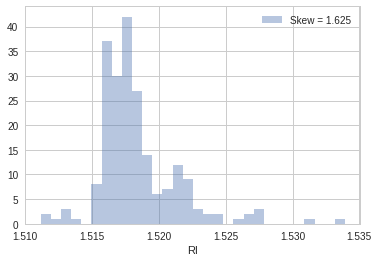

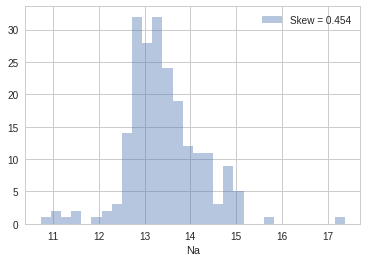

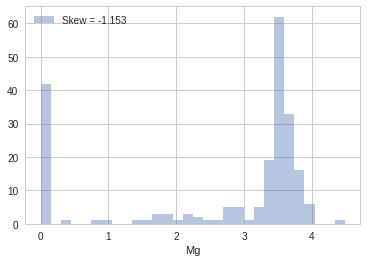

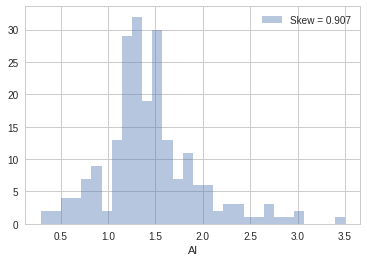

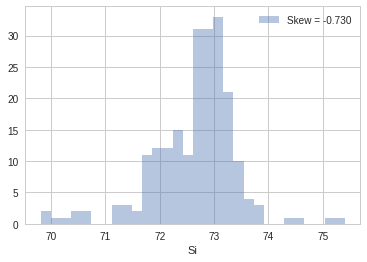

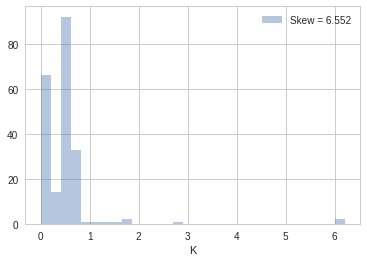

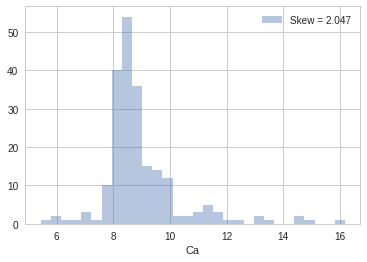

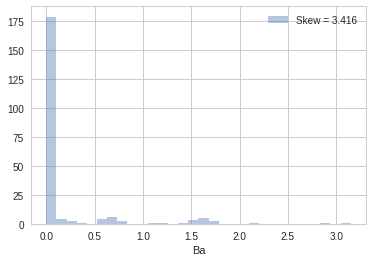

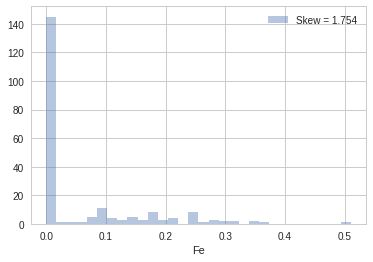

In [7]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients. Moreover, the distribution of potassium (K) and Barium (Ba) seem to contain many outliers.
Let's identify the indices of the observations containing outliers using [Turkey's method](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/).

In [8]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))   

The dataset contains 14 observations with more than 2 outliers


Aha! there exists some 14 observations with multiple outliers.  These  could harm the efficiency of our learning algorithms. We'll make sure to get rid of these in the next sections.

Let's examine the boxplots for the several distributions.

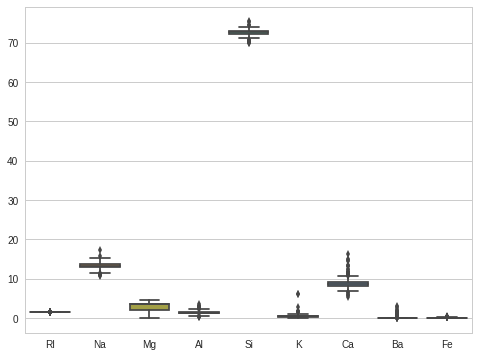

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(df[features])
plt.show()

Unsurprisingly, Silicon has a mean that is much superior to the other constituents as we already saw in the previous section. Well, that is normal since glass is mainly based on silica.

* **Multivariate plots**

Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

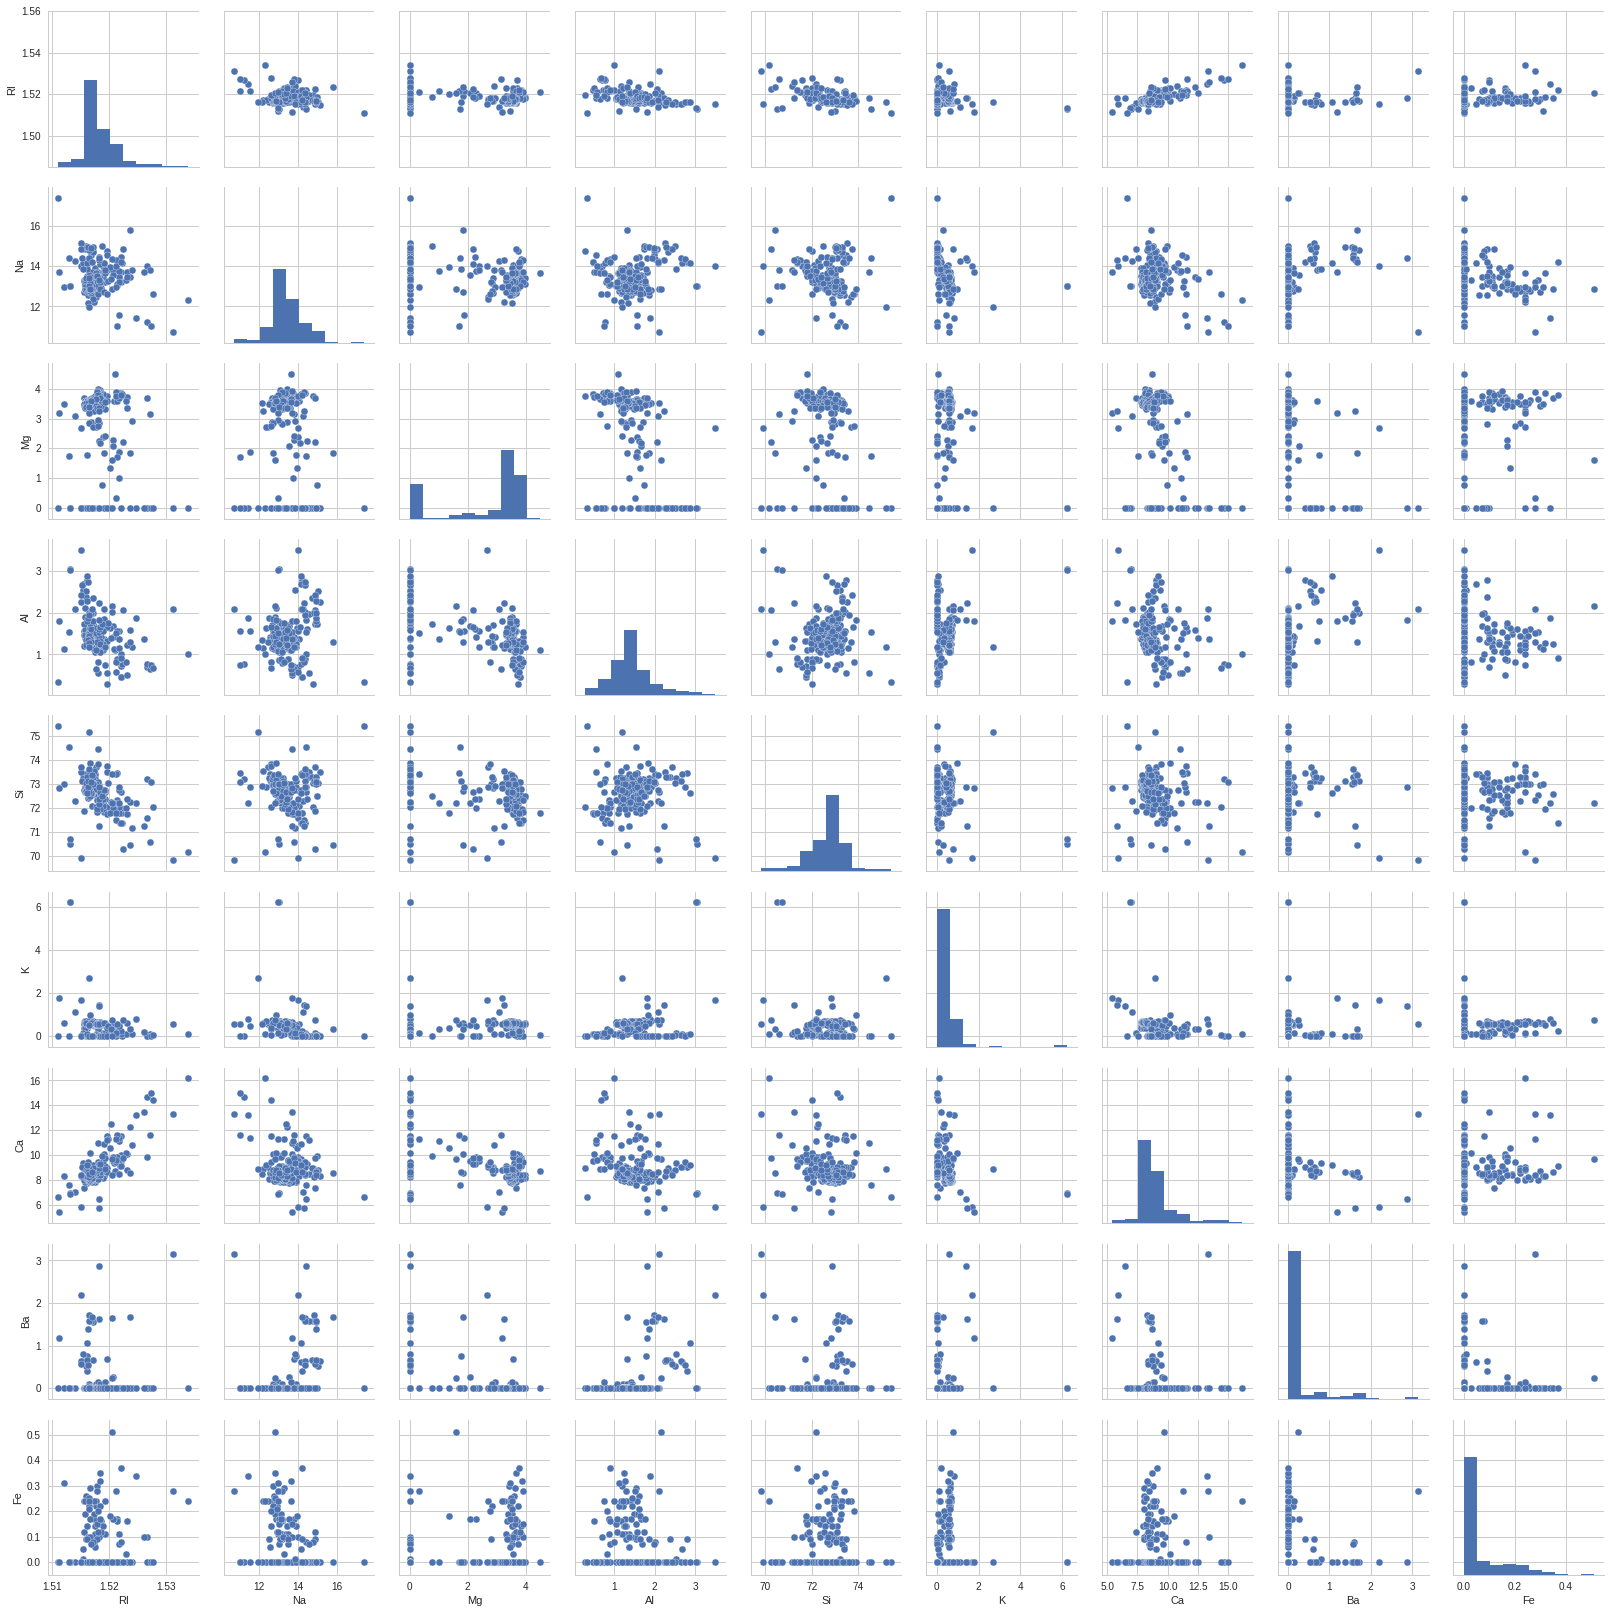

In [10]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

Let's go ahead and examine a heatmap of the correlations.

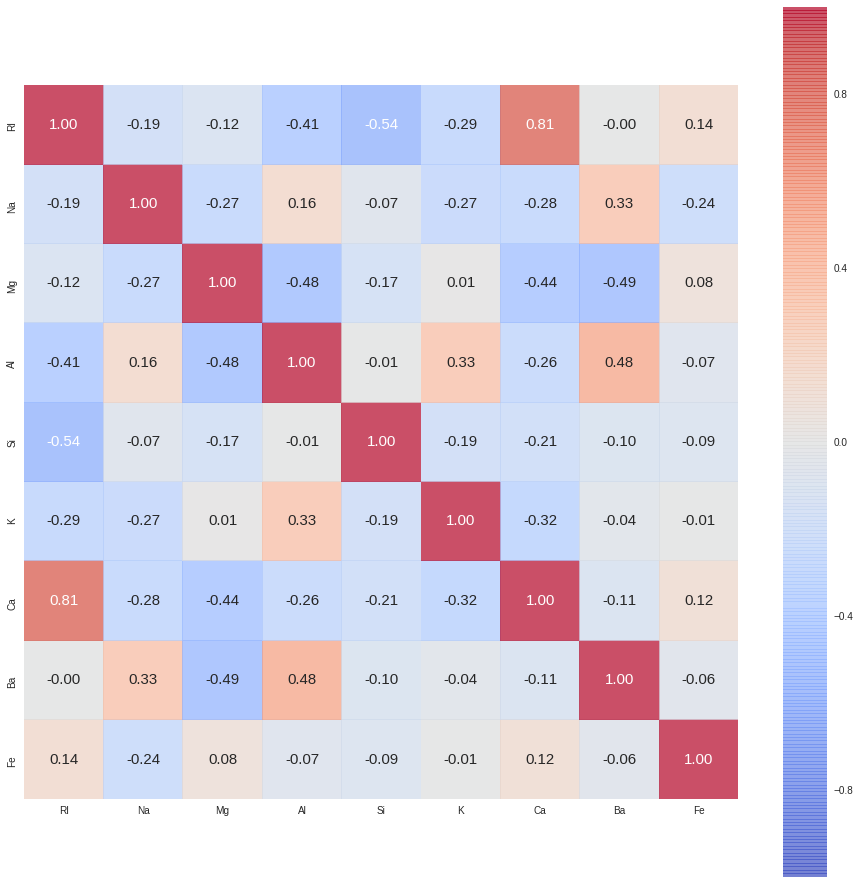

In [11]:
corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

There seems to be a strong positive correlation between RI and Ca. This could be a hint to perform Principal component analysis in order to decorrelate some of the input features.

## 3. Prepare data

### - Data cleaning 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


This dataset is clean; there aren't any missing values in it.

### - Hunting and removing multiple outliers

Let's remove the observations containing multiple outliers with the function we created in the previous section.

In [13]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


Removing observations with multiple outliers (more than 2) leaves us with 200 observations to learn from. Let's now see how our distributions look like.

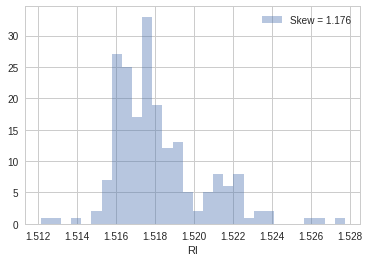

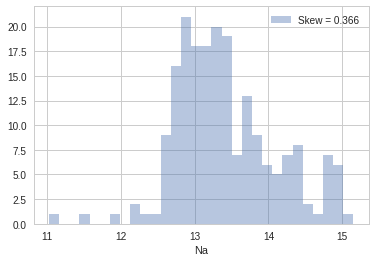

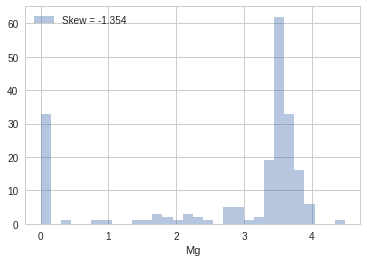

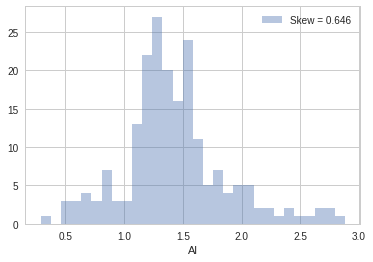

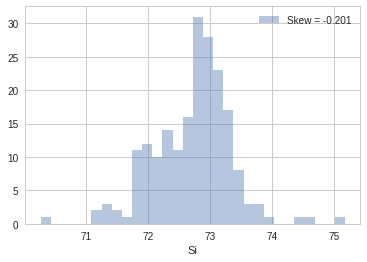

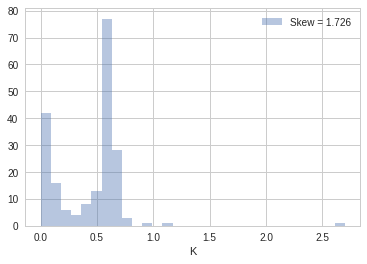

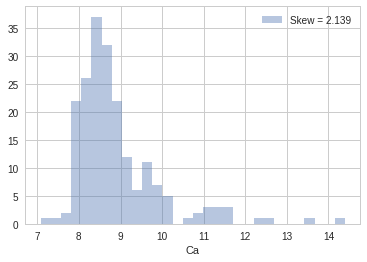

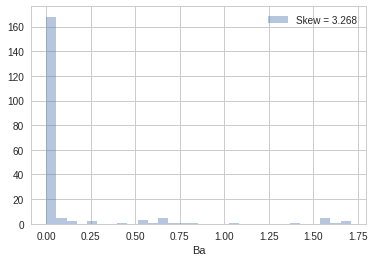

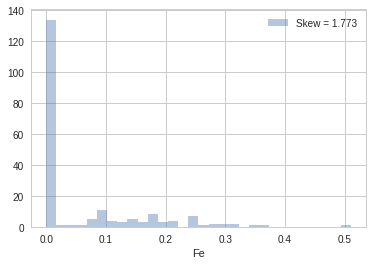

In [14]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [15]:
df['Type'].value_counts()

2    70
1    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

Let's now plot a distribution of the Types.

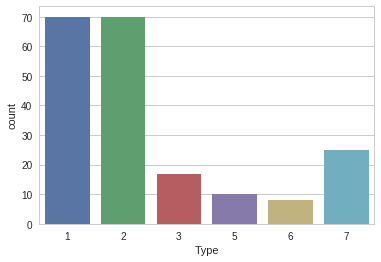

In [16]:
sns.countplot(df['Type'])
plt.show()

### - Split-out validation dataset

In [17]:
# Define X as features and y as lablels
X = df[features] 
y = df['Type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

### - Data transformation  

Let's examine if a Box-Cox transform can contribute to the normalization of some features. It should be emphasized that all transformations should only be done on the training set to avoid data snooping. Otherwise the test error estimation will be biased.

In [18]:
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']

In [19]:
df_bc.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,2.000000e+02,200.000000,200.000000,200.000000
mean,0.002223,0.910643,14.813501,0.955244,6.066998e+09,0.342872,1.999247e-01,0.013377,0.019141,2.670000
std,0.000000,0.003076,8.011923,0.217702,2.873436e+08,0.213507,8.577883e-07,0.031188,0.027757,2.054802
min,0.002223,0.897962,0.000000,0.261374,5.004527e+09,0.000000,1.999213e-01,0.000000,0.000000,1.000000
25%,0.002223,0.908540,10.569803,0.850076,5.893055e+09,0.122922,1.999242e-01,0.000000,0.000000,1.000000
50%,0.002223,0.910269,18.555034,0.938477,6.106880e+09,0.447403,1.999247e-01,0.000000,0.000000,2.000000
75%,0.002223,0.912445,19.835863,1.060851,6.238683e+09,0.480536,1.999252e-01,0.000000,0.051652,3.000000
max,0.002223,0.917711,31.408319,1.561947,7.292985e+09,1.392148,1.999269e-01,0.091142,0.068796,7.000000


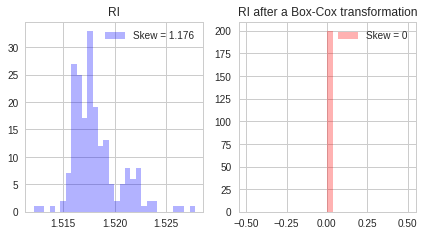

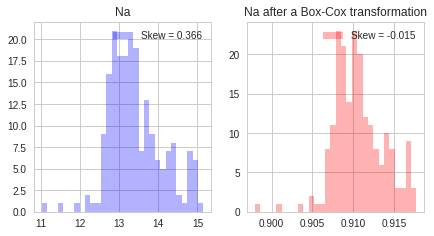

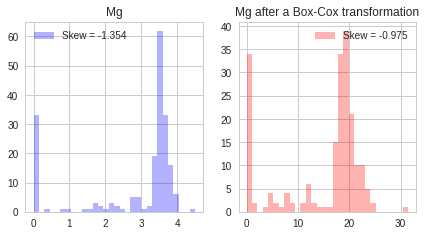

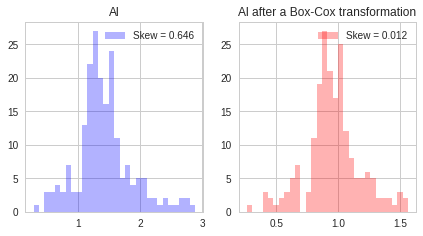

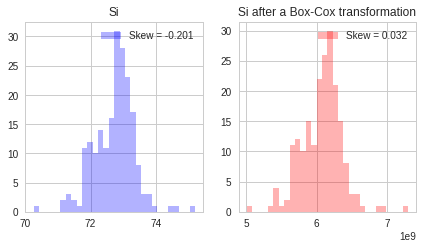

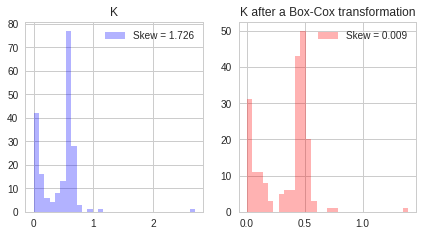

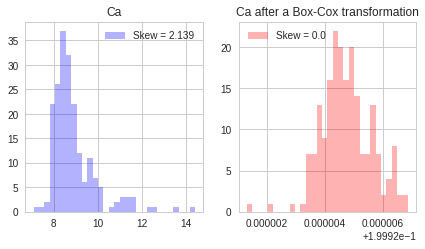

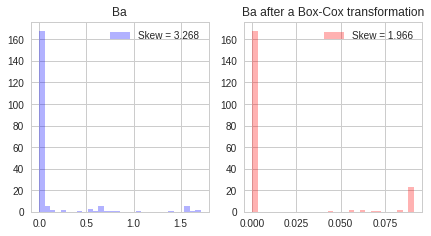

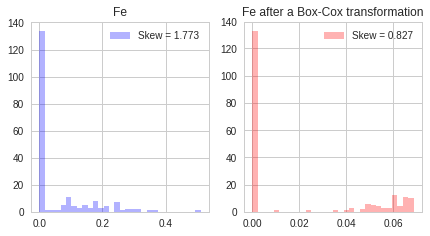

In [20]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [21]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform


The Box-Cox transform seems to do a good job in reducing the skews of the different distributions of features.  However, it does not lead to the normalization of the feature distributions. Trial and error showed that it doesn't lead to an improvement of the performance of the used algorithms.  Next, let's explore dimensionality reduction techniques.

## 4. Evaluate Algorithms

### - Dimensionality reduction

* **XGBoost**

Elapsed time to train XGBoost  164.957 seconds


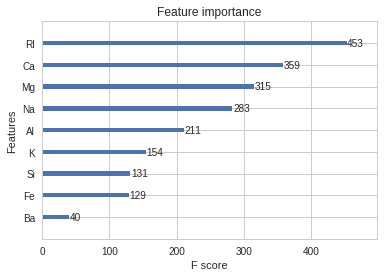

In [22]:
model_importances = XGBClassifier()
start = time()
model_importances.fit(X_train, y_train)
print('Elapsed time to train XGBoost  %.3f seconds' %(time()-start))
plot_importance(model_importances)
plt.show()

It appears that no main features dominate the importance in the XGBoost modeling of the problem. 

* **PCA**

Let's go ahead and perform a PCA on the features to decorrelate the ones that are linearly dependent and then let's plot the cumulative explained variance.

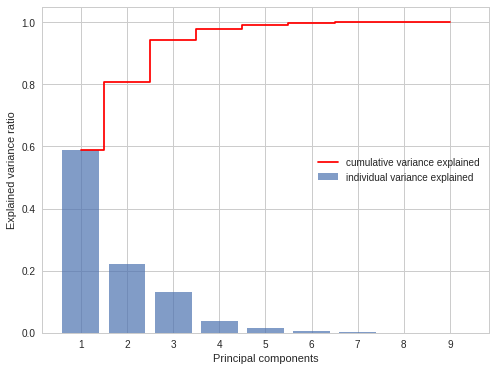

PC1 Cumulative variance: 58.837%
PC2 Cumulative variance: 80.887%
PC3 Cumulative variance: 94.102%
PC4 Cumulative variance: 97.748%
PC5 Cumulative variance: 99.159%
PC6 Cumulative variance: 99.752%
PC7 Cumulative variance: 99.977%
PC8 Cumulative variance: 100.000%
PC9 Cumulative variance: 100.000%


In [23]:
pca = PCA(random_state = seed)
pca.fit(X_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()

# Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print("PC" + str(i+1), "Cumulative variance: %.3f% %" %(cum_var_exp[i]*100))

It appears that about 99 % of the variance can be explained with the first 5 principal components. However feeding the PCA features to the learning algorithms did not contribute to a better performance. This might be due to the non-linearites that PCA is not able to capture.

### - Compare Algorithms

Now it's time to compare the performance of different machine learning algorithms. We'll use 10-folds cross-validation to assess the performance of each model with the metric being the classification accuracy. Pipelines encompassing Standarization and PCA are used in order to avoid data leakage. Standarization is not performed for tree-based methods.

SVC: 71.430587 (+/- 8.222655) performed in 0.395494 seconds
KNN: 67.772914 (+/- 10.418318) performed in 0.351453 seconds
RF: 78.190797 (+/- 9.015282) performed in 2.008495 seconds
Ada: 46.211231 (+/- 7.623465) performed in 2.202960 seconds
ET: 75.904677 (+/- 6.876377) performed in 2.013953 seconds
GB: 74.091032 (+/- 11.114344) performed in 2.397778 seconds
LR: 70.025502 (+/- 9.168266) performed in 0.343853 seconds


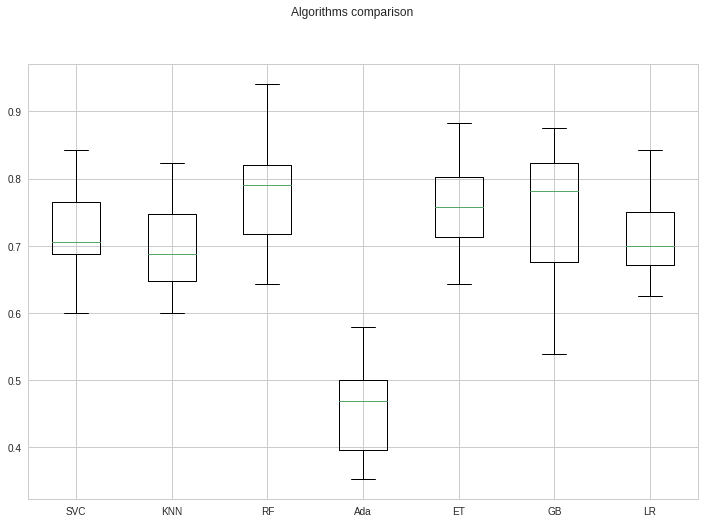

In [24]:
n_components = 5
pipelines = []
n_estimators = 200

#print(df.shape)
pipelines.append( ('SVC',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ),
                             ('SVC', SVC(random_state=seed))]) ) )


pipelines.append(('KNN',
                  Pipeline([ 
                              ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ),
                            ('KNN', KNeighborsClassifier()) ])))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))


pipelines.append( ('Ada',
                   Pipeline([ 
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                    ('Ada', AdaBoostClassifier(random_state=seed,  n_estimators=n_estimators)) ]) ))

pipelines.append( ('ET',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('ET', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))
pipelines.append( ('GB',
                   Pipeline([ 
                             ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('GB', GradientBoostingClassifier(random_state=seed)) ]) ))

pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))

results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    start = time()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = scoring,
                                n_jobs=-1) 
    t_elapsed = time() - start
    results.append(cv_results)
    names.append(name)
    times.append(t_elapsed)
    msg = "%s: %f (+/- %f) performed in %f seconds" % (name, 100*cv_results.mean(), 
                                                       100*cv_results.std(), t_elapsed)
    print(msg)


fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


**Observation:** The best performances are achieved by RF. However, RF also yields a wide distribution. It is worthy to continue our study by tuning RF. 

Logistic Regression performs badly. This might be due to the fact that the data is not normally distributed as these algorithms perform well when data that is normally distributed.

## 5. Algorithm tuning

### Tuning Random Forests

For random forest, we can tune the number of grown trees (n_estimators), the trees' depth (max_depth), the criterion of splitting (gini or entropy) and so on.... Let's start tuning these.

In [25]:
# Create a pipeline with a Random forest classifier
pipe_rfc = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=seed, n_jobs=-1) )])

# Set the grid parameters
param_grid_rfc =  [ {
    'rfc__n_estimators': [100, 200,300,400], # number of estimators
    #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=num_folds, random_state= seed)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring=scoring, verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_rfc = grid_rfc.fit(X_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.7min finished


RFC grid search took 102.592 seconds
-------Best score----------
76.25
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 200}


## 6) Diagnose the performance of the best algorithms

### Diagnose overfitting by plotting the learning and validation curves

In [26]:
# Let's define some utility functions to plot the learning & validation curves

def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel('Accuracy')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()    
    
def plot_validation_curve(param_range, train_scores, test_scores, title, alpha=0.1):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(param_range,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(param_range, test_mean, label='test score', color='red', marker='o')
    plt.fill_between(param_range,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.grid(ls='--')
    plt.xlabel('Parameter value')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()    

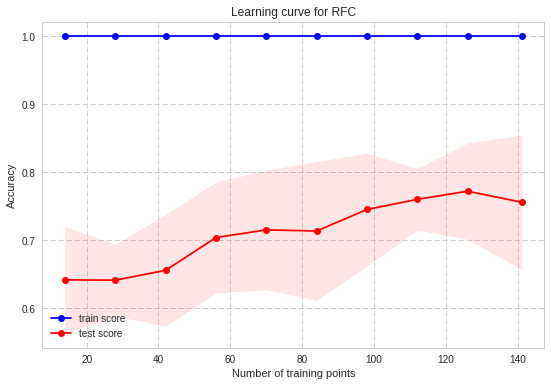

In [27]:
plt.figure(figsize=(9,6))

train_sizes, train_scores, test_scores = learning_curve(
              estimator= grid_rfc.best_estimator_ , X= X_train, y = y_train, 
                train_sizes=np.arange(0.1,1.1,0.1), cv= 10,  scoring='accuracy', n_jobs= - 1)

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for RFC')

The algorithm suffers from high variance.